<a href="https://colab.research.google.com/github/adsmbr/Tarefa_Triggo/blob/main/Tarefa_Triggo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nulos por tabela: {'customers': np.int64(0), 'geolocation': np.int64(0), 'orders': np.int64(4908), 'order_items': np.int64(0), 'order_payments': np.int64(0), 'order_reviews': np.int64(145903), 'products': np.int64(3071), 'sellers': np.int64(0), 'cat_translation': np.int64(0)}


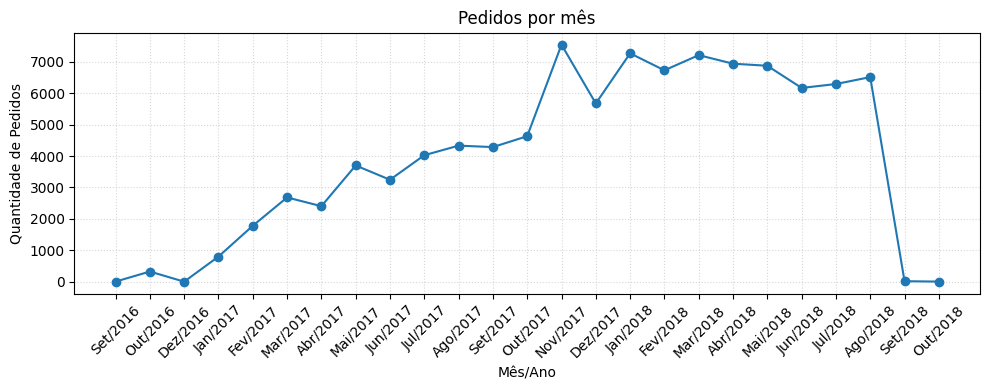

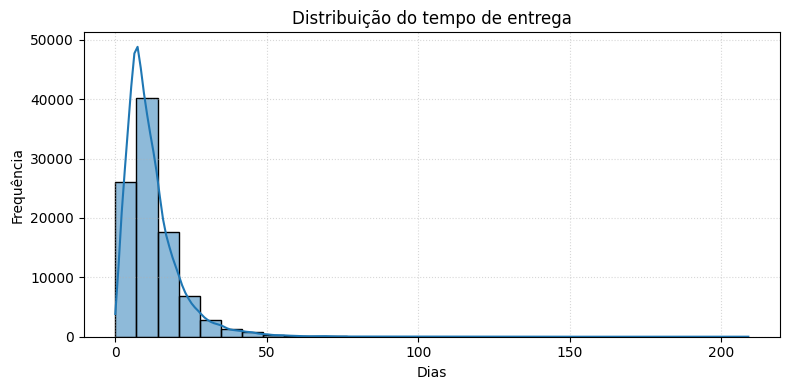

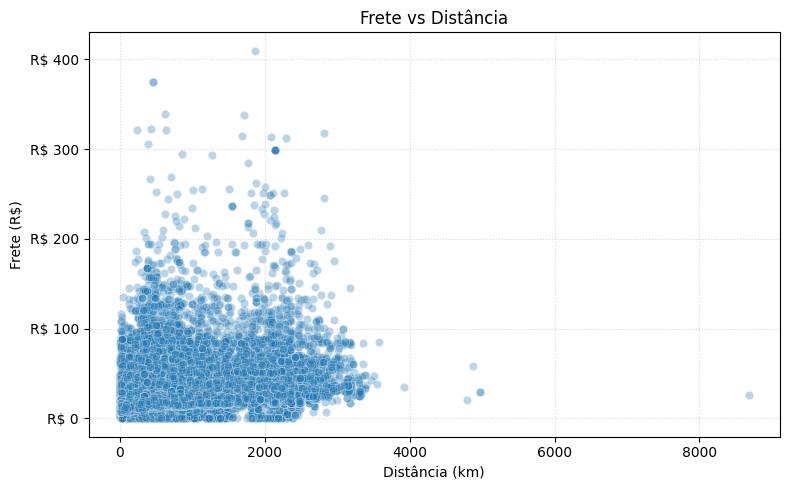

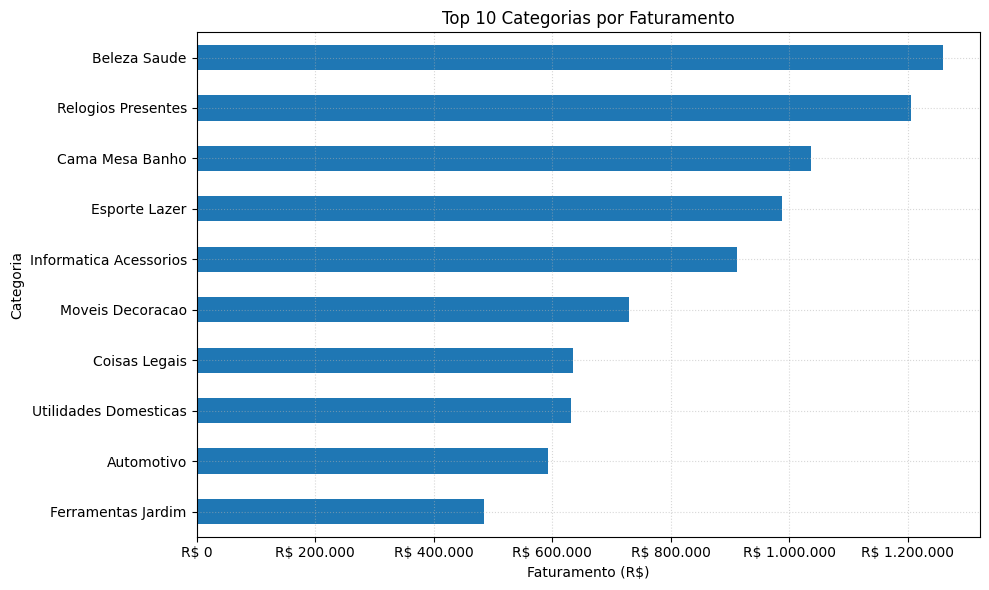

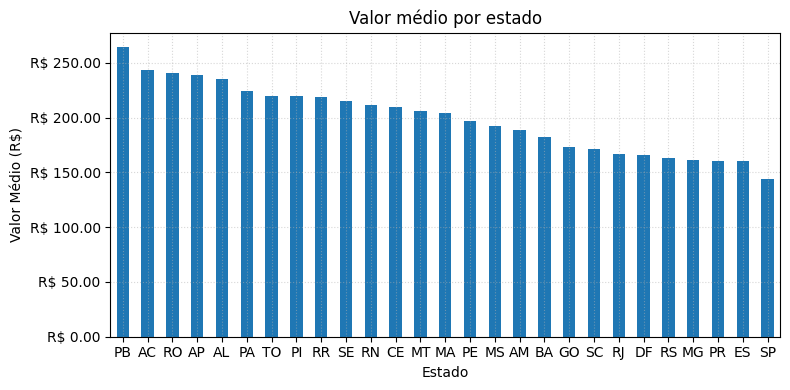

Taxa de clientes recorrentes: 0.00%
              precision    recall  f1-score   support

    No prazo       0.92      0.98      0.95     18123
      Atraso       0.18      0.05      0.08      1611

    accuracy                           0.90     19734
   macro avg       0.55      0.51      0.51     19734
weighted avg       0.86      0.90      0.88     19734



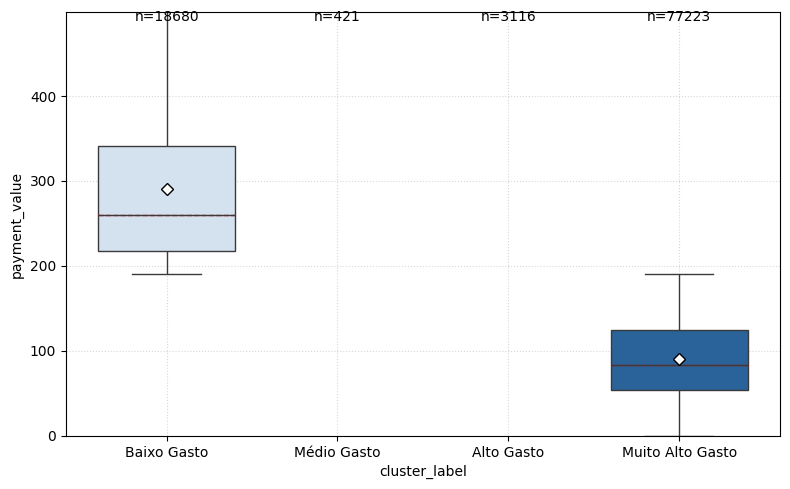

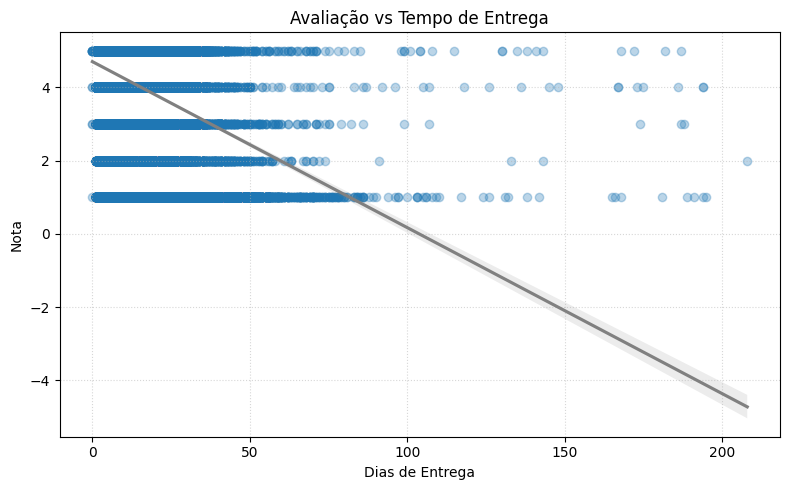

5. Conclusões
- Picos de pedidos em Nov/Dez indicam datas sazonais.
- Entregas rápidas geram melhores notas.
- Correlação entre distância e frete reforça logística.
- Segmentação revela perfis para marketing.
- SP e RJ lideram faturamento.
- Categorias top: Beleza e Saúde; Relógios e Presentes; Cama, Mesa e Banho.
- Modelo RandomForest mostrou viabilidade na predição de atrasos.



In [1]:
# Olist E-Commerce Dataset Analysis
# 1. Preparação dos Dados
## 1.1. Importação de Bibliotecas
!pip install scikit-learn plotly geopandas requests --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import sqlite3
from math import radians, cos, sin, asin, sqrt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FuncFormatter
import requests
import geopandas as gpd
import warnings
warnings.simplefilter('ignore')

## 1.2. Carregamento dos Arquivos CSV
dfs = {
    'customers': 'olist_customers_dataset.csv',
    'geolocation': 'olist_geolocation_dataset.csv',
    'orders': 'olist_orders_dataset.csv',
    'order_items': 'olist_order_items_dataset.csv',
    'order_payments': 'olist_order_payments_dataset.csv',
    'order_reviews': 'olist_order_reviews_dataset.csv',
    'products': 'olist_products_dataset.csv',
    'sellers': 'olist_sellers_dataset.csv',
    'cat_translation': 'product_category_name_translation.csv'
}

data = {}
for name, path in dfs.items():
    try:
        data[name] = pd.read_csv(path)
    except FileNotFoundError:
        try:
            data[name] = pd.read_csv(path.split('/')[-1])
        except Exception:
            raise FileNotFoundError(f"Não foi possível encontrar o arquivo {path} nem {path.split('/')[-1]}")

## 1.3. Limpeza e Normalização
def limpa_duplicatas(dfs):
    for df in dfs.values():
        df.drop_duplicates(inplace=True)

limpa_duplicatas(data)

def padroniza_colunas(dfs):
    for df in dfs.values():
        df.columns = df.columns.str.lower()

padroniza_colunas(data)

# Traduzir categorias
data['products'] = (
    data['products']
    .merge(data['cat_translation'], on='product_category_name', how='left')
    .assign(
        product_category_name=lambda df: df['product_category_name'].replace({
            'cool_stuff': 'Coisas Legais',
            'fashion_bags_accessories': 'Moda Bolsas e Acessórios',
            'home_confort': 'Casa Conforto',
            'sports_leisure': 'Esportes e Lazer',
            'bed_bath_table': 'Cama Mesa e Banho',
            'computers_accessories': 'Informática e Acessórios'
        })
    )
)

total_nulos = {k: v.isnull().sum().sum() for k, v in data.items()}
print("Nulos por tabela:", total_nulos)

## 1.4. Modelo Relacional em SQLite
conn = sqlite3.connect(':memory:')
for name, df in data.items():
    tab = 'category_translation' if name == 'cat_translation' else name
    df.to_sql(tab, conn, index=False)

# 2. Análise Exploratória
meses_pt = {
    1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Abr', 5: 'Mai', 6: 'Jun',
    7: 'Jul', 8: 'Ago', 9: 'Set', 10: 'Out', 11: 'Nov', 12: 'Dez'
}

## 2.1. Pedidos por mês
monthly = pd.read_sql(
    "SELECT substr(order_purchase_timestamp,1,7) AS month, COUNT(order_id) AS total_orders FROM orders GROUP BY month ORDER BY month;",
    conn
)
monthly['month_dt'] = pd.to_datetime(monthly['month'] + '-01')
monthly['month_fmt'] = monthly['month_dt'].dt.month.map(meses_pt) + '/' + monthly['month_dt'].dt.year.astype(str)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(monthly['month_fmt'], monthly['total_orders'], marker='o')
ax.set(title='Pedidos por mês', xlabel='Mês/Ano', ylabel='Quantidade de Pedidos')
ax.tick_params(axis='x', rotation=45)
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

## 2.2. Tempo de Entrega
orders = data['orders'].copy()
orders['purchase'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['delivered'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['delivery_days'] = (orders['delivered'] - orders['purchase']).dt.days

fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(orders['delivery_days'].dropna(), bins=30, kde=True, ax=ax)
ax.set(title='Distribuição do tempo de entrega', xlabel='Dias', ylabel='Frequência')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

## 2.3. Frete vs Distância
geo = data['geolocation'].groupby('geolocation_zip_code_prefix')[['geolocation_lat','geolocation_lng']].mean().reset_index()
order_items = data['order_items']
oc = data['customers'][['customer_id','customer_zip_code_prefix']]
osl = data['sellers'][['seller_id','seller_zip_code_prefix']]

merged = (
    orders[['order_id','customer_id']]
    .merge(order_items[['order_id','seller_id','freight_value']], on='order_id')
    .merge(oc, on='customer_id')
    .merge(osl, on='seller_id')
    .merge(geo, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
    .merge(geo, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', suffixes=('_cust','_sell'))
)

merged['distance_km'] = merged.apply(lambda r: 6371*2*asin(sqrt(
    sin((radians(r.geolocation_lat_sell)-radians(r.geolocation_lat_cust))/2)**2 +
    cos(radians(r.geolocation_lat_cust))*cos(radians(r.geolocation_lat_sell))*
    sin((radians(r.geolocation_lng_sell)-radians(r.geolocation_lng_cust))/2)**2
)), axis=1)

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=merged, x='distance_km', y='freight_value', alpha=0.3, ax=ax)
ax.set(title='Frete vs Distância', xlabel='Distância (km)', ylabel='Frete (R$)')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'R$ {x:,.0f}'.replace(',', '.')))
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

## 2.4. Top Categorias por Faturamento
pr = data['products'][['product_id','product_category_name']]
cat_rev = order_items.merge(pr, on='product_id').groupby('product_category_name')['price'].sum().nlargest(10)
cat_rev.index = cat_rev.index.str.replace('_',' ').str.title()

fig, ax = plt.subplots(figsize=(10,6))
cat_rev.plot(kind='barh', ax=ax)
ax.set(title='Top 10 Categorias por Faturamento', xlabel='Faturamento (R$)', ylabel='Categoria')
ax.invert_yaxis()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'R$ {x:,.0f}'.replace(',', '.')))
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

## 2.5. Valor Médio por Estado
pay = data['order_payments'].groupby('order_id')['payment_value'].sum().reset_index()
ord = orders[['order_id','customer_id']].merge(pay, on='order_id')
cs = data['customers'][['customer_id','customer_state']]
mean_state = ord.merge(cs, on='customer_id').groupby('customer_state')['payment_value'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8,4))
mean_state.plot(kind='bar', ax=ax)
ax.set(title='Valor médio por estado', xlabel='Estado', ylabel='Valor Médio (R$)')
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'R$ {x:,.2f}'.replace(',', '.')))
plt.grid(True, linestyle=':', alpha=0.5)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Problemas de Negócio
## 3.1. Retenção de Clientes
cust_counts = orders.groupby('customer_id').size()
taxa = cust_counts[cust_counts>1].count()/cust_counts.count()
print(f"Taxa de clientes recorrentes: {taxa:.2%}")

## 3.2. Predição de Atraso
orders['estimated'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders['late'] = (orders['delivered'] > orders['estimated']).astype(int)

feat = (
    order_items[['order_id','price','freight_value']]
    .groupby('order_id').mean()
    .reset_index()
    .merge(orders[['order_id','late']], on='order_id')
    .dropna()
)

X = feat[['price','freight_value']]
y = feat['late']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
clf = RandomForestClassifier(random_state=42).fit(X_train,y_train)
pred = clf.predict(X_test)

print(classification_report(y_test,pred,target_names=['No prazo','Atraso']))

## 3.3. Segmentação de Clientes com aprimoramentos visuais
# Preparar clusters e rótulos
tot = ord.groupby('customer_id')['payment_value'].sum().reset_index()
tot['z'] = StandardScaler().fit_transform(tot[['payment_value']])
tot['cluster'] = KMeans(n_clusters=4, random_state=42).fit_predict(tot[['z']])

rotulos = {0:'Baixo Gasto',1:'Médio Gasto',2:'Alto Gasto',3:'Muito Alto Gasto'}
tot['cluster_label'] = tot['cluster'].map(rotulos)

contagens = tot['cluster_label'].value_counts().reindex(rotulos.values())

fig, ax = plt.subplots(figsize=(8,5))
sns.boxplot(x='cluster_label', y='payment_value', data=tot, order=list(rotulos.values()),
            showmeans=True, meanprops={'marker':'D','markerfacecolor':'white','markeredgecolor':'black'},
            palette='Blues', ax=ax)

medians = tot.groupby('cluster_label')['payment_value'].median().reindex(rotulos.values())
for i, m in enumerate(medians):
    ax.hlines(m, i-0.4, i+0.4, linestyles='--', linewidth=1, color='red')

y_max = tot['payment_value'].quantile(0.95)*1.1
ax.set_ylim(0, y_max)
ax.grid(True, linestyle=':', alpha=0.5)

for i, label in enumerate(rotulos.values()):
    ax.text(i, y_max * 0.98, f'n={contagens[label]}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 3.4. Satisfação vs Entrega
rev = data['order_reviews'][['order_id','review_score']].merge(orders[['order_id','delivery_days']], on='order_id')

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(x='delivery_days', y='review_score', data=rev, scatter_kws={'alpha':0.3}, line_kws={'color':'gray'}, ax=ax)
ax.set(title='Avaliação vs Tempo de Entrega', xlabel='Dias de Entrega', ylabel='Nota')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

# 4. Visualizações Interativas
## 4.1. Evolução de Pedidos (interativo)
fig = px.line(monthly, x='month_fmt', y='total_orders', title='Evolução de Pedidos')
fig.update_layout(xaxis_title='Mês/Ano', yaxis_title='Pedidos', xaxis_tickangle=45)
fig.show()

## 4.2. Mapa de Calor por Estado
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson '
heat = mean_state.reset_index().rename(columns={'customer_state':'uf','payment_value':'valor'})
heat['uf'] = heat['uf'].astype(str).str.upper()

fig = px.choropleth(heat, geojson=url, locations='uf', color='valor',
                    featureidkey='properties.sigla',
                    title='Valor Médio de Pagamento por Estado (R$)',
                    color_continuous_scale='Viridis')
fig.update_layout(coloraxis_colorbar=dict(title='Valor Médio (R$)', tickprefix='R$ ', tickformat=',.2f'))
fig.update_geos(visible=False, showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')
fig.show()

## 4.3. Avaliação x Entrega (interativo)
fig = go.Figure(go.Scatter(x=rev['delivery_days'], y=rev['review_score'], mode='markers', opacity=0.5))
fig.update_layout(title='Avaliação vs Entrega', xaxis_title='Dias de Entrega', yaxis_title='Nota')
fig.show()

## 4.4. Dashboard de Vendedores
sv = merged.merge(data['order_reviews'][['order_id','review_score']], on='order_id').groupby('seller_id').agg(
    pedidos=('order_id','count'),
    avg_score=('review_score','mean'),
    avg_deliv=('distance_km','mean')
).reset_index()
fig = px.scatter(sv, x='avg_score', y='pedidos', size='avg_deliv', hover_name='seller_id', title='Desempenho dos Vendedores')
fig.update_layout(xaxis_title='Nota Média', yaxis_title='Pedidos')
fig.show()

# 5. Conclusões
conclusoes = """5. Conclusões
- Picos de pedidos em Nov/Dez indicam datas sazonais.
- Entregas rápidas geram melhores notas.
- Correlação entre distância e frete reforça logística.
- Segmentação revela perfis para marketing.
- SP e RJ lideram faturamento.
- Categorias top: Beleza e Saúde; Relógios e Presentes; Cama, Mesa e Banho.
- Modelo RandomForest mostrou viabilidade na predição de atrasos.
"""
print(conclusoes)